### Importieren der verschiedenen Packages

In [1]:
import pandas as pd
import numpy as np
import cv2

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, accuracy_score, confusion_matrix

from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

from sklearn import neighbors
from sklearn.model_selection import cross_val_score
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier


from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.utils import shuffle
import json

import seaborn as sns  # spezielle Graphikdarstellungen
from tqdm.auto import tqdm

C:\Users\thoma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Laden der Daten
Die zuvor erstellte Pickeldatei von (import_pictures) wird hier in einen DataFrame geladen. Durch Parameterübergaben können verschiedene Resampling-Möglichkeiten auf die Daten angewendet werden. Die Daten werden X und y zugeordnet. Weiterhin wird die Reihenfolge der Bilder durch "shuffle" zufällig verändert. Der Parameter random_state wird für die Nachvollziehbarkeit verwendet.

In [2]:
data = pd.read_pickle('./data/images_df_numerical.pkl')
classes = data["Species"].unique()
number_of_classes = classes.size


# Daten Laden, kein Resampling
def no_resample() -> tuple[np.array, np.array]:
    X, y = data['data'], data['Species']
    X, y = np.stack(X).astype(np.uint8), y.to_numpy().astype(np.uint8)

    return X, y

# Kein Resampling
X, y = no_resample()


# Alleiniges undersampling wird keinen Sinn machen, da wir extrem wenig Datenpunkte overall haben
def resample(resampler) -> tuple[np.array, np.array]:
    X, y = data['data'], data['Species']
    X, y = np.stack(X).astype(np.uint8), y.to_numpy().astype(np.uint8)
    X_resampled, y_resampled = resampler.fit_resample(X, y)

    print(f"{resampler}: ", pd.Series(y_resampled, dtype=pd.UInt8Dtype()).value_counts())

    X_resampled, y_resampled = shuffle(X_resampled, y_resampled, random_state=1)

    return X_resampled, y_resampled

# oversampling
#adasyn = ADASYN()
#X, y = resample(adasyn)




image_size = X[0].size
samples = X.size
with open("./data/meta.json","r") as file:  # get metadata for images from file generated from import nb
    image_meta = json.load(file) 
image_shape = (image_meta['h'],image_meta['w'],image_meta['c']) # hwc
print("Image has shape", image_shape)
# normalize to 0-1
X = X / 255.
X = X.reshape((-1,) + image_shape)

Image has shape (82, 128, 3)


## Visualisieren der Anzahl
Ein einfacher Plot, um zu veranschaulichen, wie oft jede Fledermausart vorkommt.

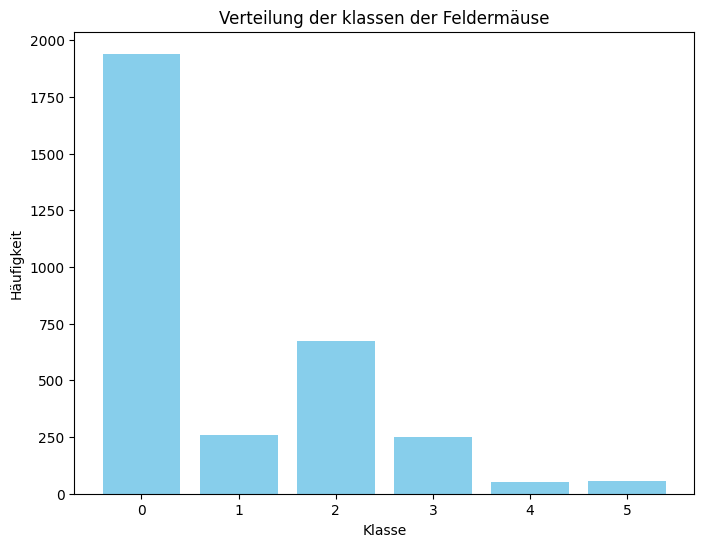

(array([0, 1, 2, 3, 4, 5], dtype=uint8), array([1940,  260,  675,  251,   53,   58], dtype=int64))


In [4]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8,6))
unique, counts = np.unique(y, return_counts=True)
plt.bar(unique, counts, color="skyblue")

plt.title("Verteilung der klassen der Feldermäuse")
plt.xlabel("Klasse")
plt.ylabel("Häufigkeit")

plt.show()

print(np.unique(y, return_counts=True))

## Split Train- und Testdaten + Flatten
Durch die folgende Funktion werden die Daten in die passende Form gebracht und in eine Trainings- und Testmenge aufgeteilt, sodass sie für Klassifikationsbäume verwendet werden können.

**Anmerkung**: Durch das Flatten werden die Strukturen der Fledermausstimmen zerstört. Die räumliche Aufteilung der Stimmen ist dadurch nicht mehr zuzuordnen. In bestimmten Fällen kann dies von Vorteil sein, in unserem Projekt ist es jedoch ein erheblicher Nachteil.

In [7]:
def split_and_flatten_data(X, y, test_size=0.25):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=1)

    X_train = np.array(X_train)
    X_test = np.array(X_test)

    y_train = np.array(y_train)
    y_test = np.array(y_test)

    #Flatten der Daten

    X_train_flatten = X_train.reshape(len(X_train), -1)
    X_test_flatten = X_test.reshape(len(X_test), -1)

    return  X_train_flatten, X_test_flatten, y_train, y_test

# Klassifikationsfaktoren
Anmerkung: Im Folgenden wird ausschließlich der CART-Algorithmus bei den Klassifikationsbaum-Algorithmen verwendet (Standard in Scikit-Learn). Dadurch entstehen ausschließlich Binärbäume.

## Funktion für einfachen Decision Tree
Mit den folgenden Funktionen können einfache Entscheidungsbäume erstellt und ausgewertet werden.

In [8]:
from sklearn.tree import DecisionTreeClassifier
#bat_tree = DecisionTreeClassifier(max_depth=10, criterion="entropy")

def fit_tree(X_train, y_train, max_depth=1, criterion="gini", min_samples_leaf=4,):

    bat_tree=DecisionTreeClassifier(max_depth=max_depth, criterion=criterion)
    bat_tree.fit(X_train,y_train)
    return bat_tree

def evaluate_model(model, X_train, y_train, X_test, y_test,):
    #predictions
    y_hat_tr = model.predict(X_train)
    y_hat_test = model.predict(X_test)

    #bat_score = accuracy_score(y_hat_test, y_test)
    bat_tr_score=model.score(X_train, y_train, sample_weight=None)
    bat_test_score=model.score(X_test, y_test, sample_weight=None)

      # print("bat_score", bat_score)
      # print('Trainings-Score:',bat_tr_score,'; Test-Score:',bat_test_score)
      # print('Confusion matrix:\n', confusion_matrix(y_test, y_hat_test))
      # print(classification_report(y_test, y_hat_test,digits=3))

    return  bat_tr_score, bat_test_score


## Erstellen eines einfachen Decision Trees
Im Folgenden werden verschiedene Baumtiefen getestet. Zudem werden als "Maß der Unreinheit" Gini und Entropie genutzt. Die Idee dahinter ist, dass es optimal wäre, die Fledermäuse mit einem White-Box-Modell zu klassifizieren. Dies wäre das bestmögliche Szenario, obwohl es so gut wie ausgeschlossen ist, da die "Eingabedaten" sehr hochdimensional sind. 
-> Einfache Decision Trees werden im Projekt nur als "erste" Referenzen verwendet (leicht und schnell zu erstellen).

In [8]:

max_depth_values = range(1,20)
criterion_values = ["gini", "entropy"]

train_acc_dict = {}
test_acc_dict = {}

for depth in tqdm(max_depth_values):
    for criterion in tqdm(criterion_values):
        # Trainings- und Testdaten aufteilen
        X_train, X_test, y_train, y_test = split_and_flatten_data(X, y, test_size=0.25)
        
        # Modell trainieren
        model = fit_tree(X_train, y_train, max_depth=depth, criterion=criterion)
        
        # Modell evaluieren
        train_acc, test_acc = evaluate_model(model, X_train, y_train, X_test, y_test)
        
        # Ergebnisse speichern
        train_acc_dict[(depth, criterion)] = train_acc
        test_acc_dict[(depth, criterion)] = test_acc

100%|██████████| 19/19 [12:24<00:00, 39.20s/it]


### Plotten der einfachen Klassifikationsbäume
Im Folgenden werden die zuvor erstellten Bäume geplottet. Dadurch kann leicht erkannt werden, wie die Bäume auf die jeweiligen Daten performen (Overfitting).

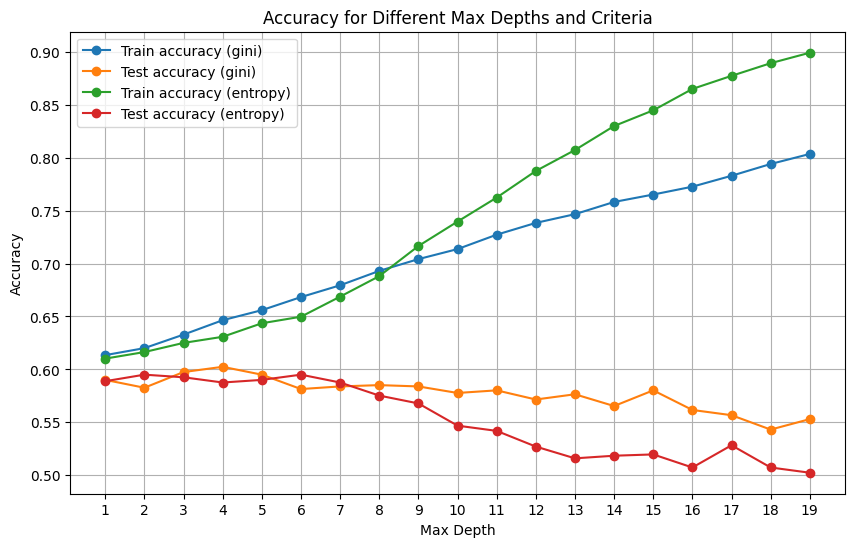

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Hier nehmen wir an, dass train_acc_dict und test_acc_dict bereits definiert und gefüllt sind

depths = range(1, 20)
criterion_values = ["gini", "entropy"]

# Extrahiere die Test- und Trainingsgenauigkeiten für die verschiedenen Kriterien
train_accs_gini = [train_acc_dict[(depth, 'gini')] for depth in depths]
test_accs_gini = [test_acc_dict[(depth, 'gini')] for depth in depths]

train_accs_entropy = [train_acc_dict[(depth, 'entropy')] for depth in depths]
test_accs_entropy = [test_acc_dict[(depth, 'entropy')] for depth in depths]

# Plotte die Ergebnisse
plt.figure(figsize=(10, 6))
plt.plot(depths, train_accs_gini, marker='o', label='Train accuracy (gini)')
plt.plot(depths, test_accs_gini, marker='o', label='Test accuracy (gini)')
plt.plot(depths, train_accs_entropy, marker='o', label='Train accuracy (entropy)')
plt.plot(depths, test_accs_entropy, marker='o', label='Test accuracy (entropy)')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Accuracy for Different Max Depths and Criteria')
plt.xticks(np.arange(1, 20, step=1))  # X-Achsenbeschriftung für jeden Max Depth
plt.legend()
plt.grid(True)
plt.show()


Generell war in den verschiedenen Durchläufen (verschiedene Filter, Anzahl der Klassen) zu erkennen, dass je tiefer die Bäume werden, desto mehr neigen sie zu Overfitting. Um das Overfitting zu reduzieren, wäre eine Möglichkeit, die Hyperparameter (max_depth, min_samples_split, min_samples_leaf, max_leaf_nodes) weiter einzuschränken. Dies wurde vereinzelt getestet. Das Modell ist für die Aufgabe nicht wirklich geeignet. Dies lässt sich dadurch begründen, dass grundsätzlich die Komplexität der Daten nicht in einem einzigen Baum dargestellt werden kann. Dies wird verstärkt durch unsere Daten. Die Daten besitzen trotz verschiedener Filter ein leichtes Rauschen, und die Klassen sind ungleichmäßig aufgeteilt.

Es ist anzumerken, dass der Grad zwischen Underfitting und Overfitting sehr schmal ist und es nicht lohnenswert ist, intensiv zu optimieren, da das Ergebnis trotzdem nicht zufriedenstellend sein wird.

## Random Forest (Bagging)
Anstatt einen BaggingClassifier zu erstellen und diesem einen DecisionTreeClassifier zu übergeben, wird der RandomForestClassifier verwendet, da dieser speziell für Entscheidungsbäume optimiert wurde (bis auf wenige Ausnahmen gleich).

Folgender Code berechnet Modelle mit verschiedenen Parametern.

In [10]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm
import numpy as np

X_train, X_test, y_train, y_test = split_and_flatten_data(X,y, 0.25)



# Assuming X_train, y_train, X_test, y_test are defined
n_splits = 8  # You can adjust the number of splits
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=123)

i_estimators = range(1, 250, 25)
leaf_nodes = range(2, 16, 2)

random_train_acc_dict1 = {}
random_test_acc_dict1 = {}

for estimators in tqdm(i_estimators):
    for nodes in tqdm(leaf_nodes):
        train_acc_list, test_acc_list = [], []

        for train_idx, test_idx in cv.split(X_train, y_train):
            rnd_clf = RandomForestClassifier(n_estimators=estimators, max_leaf_nodes=nodes, n_jobs=-1)
            rnd_clf.fit(X_train[train_idx], y_train[train_idx])

            train_acc, test_acc = evaluate_model(rnd_clf, X_train[train_idx], y_train[train_idx],
                                                 X_train[test_idx], y_train[test_idx])

            train_acc_list.append(train_acc)
            test_acc_list.append(test_acc)

        mean_train_acc = np.mean(train_acc_list)
        mean_test_acc = np.mean(test_acc_list)

        random_train_acc_dict1[(estimators, nodes)] = mean_train_acc
        random_test_acc_dict1[(estimators, nodes)] = mean_test_acc

        # Optionally, you can print the results for each combination
        # print(f"Number of estimators: {estimators}, Max leaf nodes: {nodes}")
        # print("Mean Train accuracy:", mean_train_acc)
        # print("Mean Test accuracy:", mean_test_acc)
        # print("-" * 20)


100%|██████████| 10/10 [27:33<00:00, 165.36s/it]


### Auswertung Test und Training
Darstellung der Test und Trainingsfehler

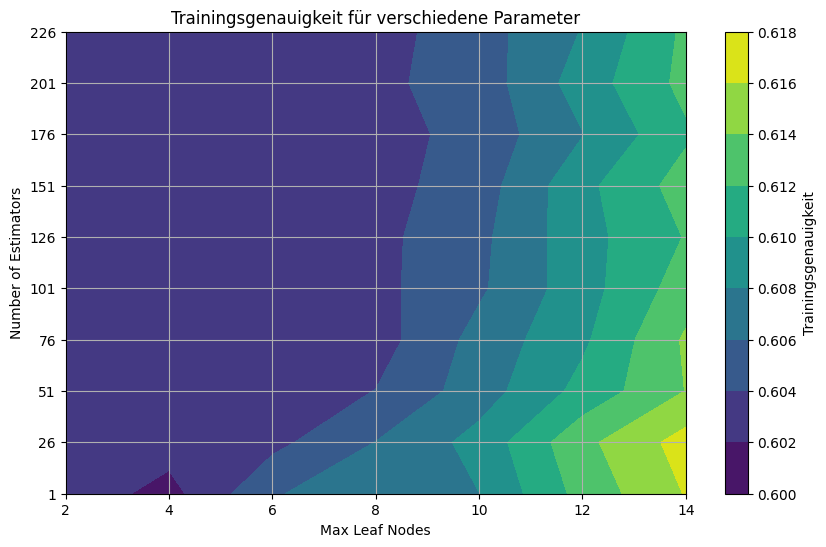

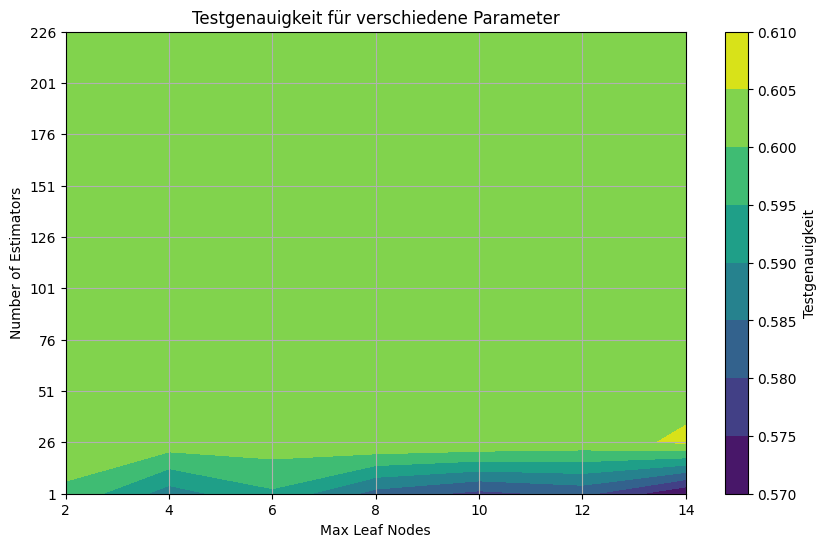

In [11]:
#print(random_train_acc_dict1)
#print()
#print()
#print(random_test_acc_dict1)

# Um die Ergebnisse plotten zu können, müssen wir die Daten in Arrays umwandeln
estimators_list = list(i_estimators)
leaf_nodes_list = list(leaf_nodes)

train_accuracy_array = np.array([[random_train_acc_dict1[(est, node)] for node in leaf_nodes_list] for est in estimators_list])
test_accuracy_array = np.array([[random_test_acc_dict1[(est, node)] for node in leaf_nodes_list] for est in estimators_list])

# Erstelle ein Konturlinien-Diagramm für Trainingsgenauigkeit
plt.figure(figsize=(10, 6))
contour = plt.contourf(leaf_nodes_list, estimators_list, train_accuracy_array, cmap='viridis')
plt.colorbar(contour, label='Trainingsgenauigkeit')
plt.xlabel('Max Leaf Nodes')
plt.ylabel('Number of Estimators')
plt.title('Trainingsgenauigkeit für verschiedene Parameter')
plt.xticks(leaf_nodes_list)
plt.yticks(estimators_list)
plt.grid(visible=True)
plt.show()

# Erstelle ein Konturlinien-Diagramm für Testgenauigkeit
plt.figure(figsize=(10, 6))
contour = plt.contourf(leaf_nodes_list, estimators_list, test_accuracy_array, cmap='viridis')
plt.colorbar(contour, label='Testgenauigkeit')
plt.xlabel('Max Leaf Nodes')
plt.ylabel('Number of Estimators')
plt.title('Testgenauigkeit für verschiedene Parameter')
plt.xticks(leaf_nodes_list)
plt.yticks(estimators_list)
plt.grid(visible=True)
plt.show()



## Extra Trees -  Extremly Randomized Trees

Bei Extra Trees wird der Bias gegen eine geringere Varianz eingetauscht. Das Ziel ist zu prüfen, welches Modell bessere Vorhersagen trifft. Dies wird mithilfe von Kreuzvalidierung bestimmt, da es im Voraus schwierig ist, dies vorherzusagen.

In [14]:
from sklearn.ensemble import ExtraTreesClassifier


n_splits = 8  # You can adjust the number of splits
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=123)

i_estimators = range(1, 250, 25)
leaf_nodes = range(2,16,2)

extra_train_acc_dict = {}
extra_test_acc_dict = {}

for estimators in tqdm(i_estimators):
    for nodes in tqdm(leaf_nodes):
        train_acc_list, test_acc_list = [], []

        for train_idx, test_idx in cv.split(X_train, y_train):
            rnd_clf = ExtraTreesClassifier(n_estimators=estimators, max_leaf_nodes=nodes, n_jobs=-1)
            rnd_clf.fit(X_train[train_idx], y_train[train_idx])

            train_acc, test_acc = evaluate_model(rnd_clf, X_train[train_idx], y_train[train_idx],
                                                 X_train[test_idx], y_train[test_idx])

            train_acc_list.append(train_acc)
            test_acc_list.append(test_acc)

        mean_train_acc = np.mean(train_acc_list)
        mean_test_acc = np.mean(test_acc_list)

        extra_train_acc_dict[(estimators, nodes)] = mean_train_acc
        extra_test_acc_dict[(estimators, nodes)] = mean_test_acc


       # print(f"Number of estimators: {estimators}")
       # print("Train accuracy:", train_acc)
       # print("Test accuracy:", test_acc)
       # print("-" * 20)


100%|██████████| 10/10 [29:36<00:00, 177.66s/it]


### Auswertung Test und Training

{(1, 2): 0.603390346115054, (1, 4): 0.6054506933744223, (1, 6): 0.6082165900242436, (1, 8): 0.6125731884135106, (1, 10): 0.613043332907542, (1, 12): 0.6168107260361585, (1, 14): 0.6171047326696313, (26, 2): 0.6028018338739995, (26, 4): 0.6028018338739995, (26, 6): 0.6028018338739995, (26, 8): 0.6029784152670997, (26, 10): 0.6031549689394161, (26, 12): 0.6042144850188014, (26, 14): 0.6071575729189675, (51, 2): 0.6028018338739995, (51, 4): 0.6028018338739995, (51, 6): 0.6028018338739995, (51, 8): 0.6028018338739995, (51, 10): 0.6029195640429943, (51, 12): 0.6035081871671844, (51, 14): 0.6050384575978456, (76, 2): 0.6028018338739995, (76, 4): 0.6028018338739995, (76, 6): 0.6028018338739995, (76, 8): 0.6028018338739995, (76, 10): 0.6030372664912051, (76, 12): 0.6030961454360945, (76, 14): 0.6043911218534692, (101, 2): 0.6028018338739995, (101, 4): 0.6028018338739995, (101, 6): 0.6028018338739995, (101, 8): 0.6028018338739995, (101, 10): 0.6028606850981049, (101, 12): 0.6030961454360945, (1

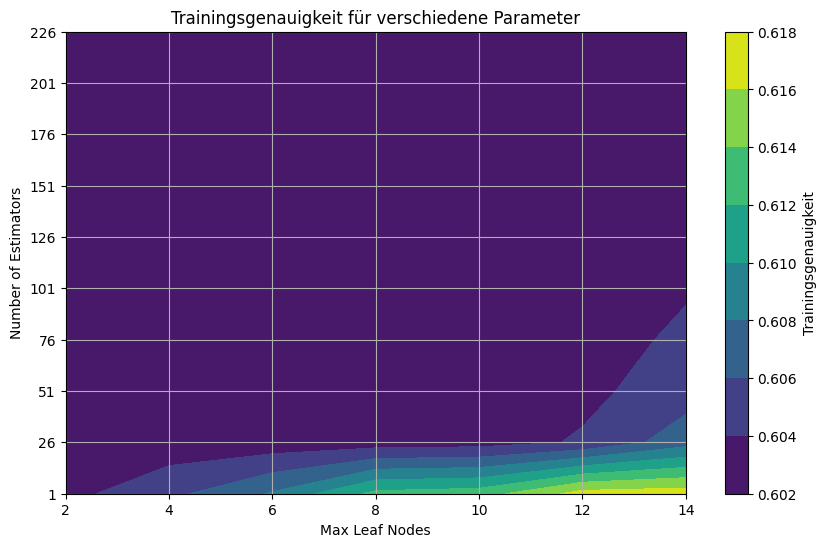

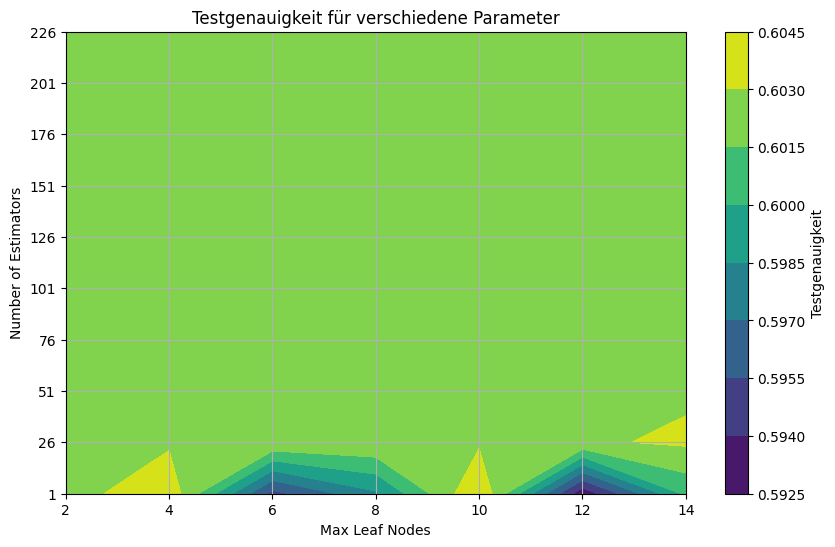

In [17]:
print(extra_train_acc_dict)
print()
print()
print(extra_test_acc_dict)

# Um die Ergebnisse plotten zu können, müssen wir die Daten in Arrays umwandeln
estimators_list = list(i_estimators)
leaf_nodes_list = list(leaf_nodes)

train_accuracy_array = np.array([[extra_train_acc_dict[(est, node)] for node in leaf_nodes_list] for est in estimators_list])
test_accuracy_array = np.array([[extra_test_acc_dict[(est, node)] for node in leaf_nodes_list] for est in estimators_list])

# Erstelle ein Konturlinien-Diagramm für Trainingsgenauigkeit
plt.figure(figsize=(10, 6))
contour = plt.contourf(leaf_nodes_list, estimators_list, train_accuracy_array, cmap='viridis')
plt.colorbar(contour, label='Trainingsgenauigkeit')
plt.xlabel('Max Leaf Nodes')
plt.ylabel('Number of Estimators')
plt.title('Trainingsgenauigkeit für verschiedene Parameter')
plt.xticks(leaf_nodes_list)
plt.yticks(estimators_list)
plt.grid(visible=True)
plt.show()

# Erstelle ein Konturlinien-Diagramm für Testgenauigkeit
plt.figure(figsize=(10, 6))
contour = plt.contourf(leaf_nodes_list, estimators_list, test_accuracy_array, cmap='viridis')
plt.colorbar(contour, label='Testgenauigkeit')
plt.xlabel('Max Leaf Nodes')
plt.ylabel('Number of Estimators')
plt.title('Testgenauigkeit für verschiedene Parameter')
plt.xticks(leaf_nodes_list)
plt.yticks(estimators_list)
plt.grid(visible=True)
plt.show()



### Darstellung der besten 10 Test und Trainingsfehler

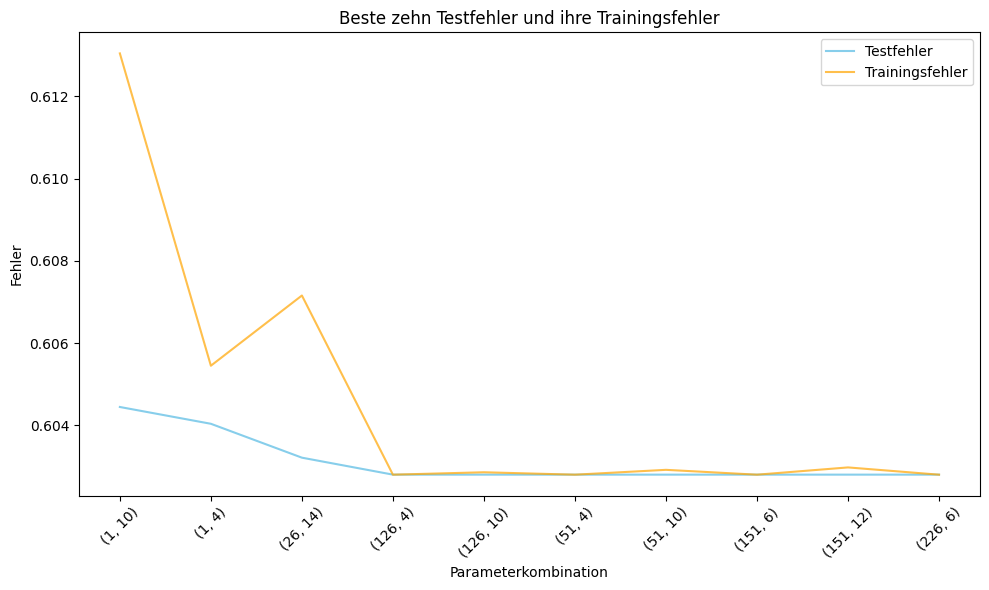

In [18]:
import matplotlib.pyplot as plt

# Annahme: Die Dictionaries extra_train_acc_dict und extra_test_acc_dict sind vorhanden und enthalten Trainings- und Testgenauigkeiten

sorted_dict_train = {k: v for k, v in sorted(extra_train_acc_dict.items(), key=lambda item: item[1], reverse=True)}
sorted_dict_test = {k: v for k, v in sorted(extra_test_acc_dict.items(), key=lambda item: item[1], reverse=True)}

common_keys = set(extra_train_acc_dict.keys()) & set(extra_test_acc_dict.keys())

common_elements = {key: (extra_train_acc_dict[key], extra_test_acc_dict[key]) for key in common_keys}

# Sortiere die gemeinsamen Elemente nach den Testfehlern in absteigender Reihenfolge und wähle die besten zehn aus
sorted_common_elements = sorted(common_elements.items(), key=lambda x: x[1][1], reverse=True)[:10]

best_test_errors = []
best_train_errors = []
best_params = []

for key, value in sorted_common_elements:
    best_params.append(str(key))
    best_train_errors.append(value[0])
    best_test_errors.append(value[1])

# Erstelle ein Balkendiagramm für die besten zehn Testfehler und ihre Trainingsfehler
plt.figure(figsize=(10, 6))
plt.plot(best_params, best_test_errors, color='skyblue', label='Testfehler')
plt.plot(best_params, best_train_errors, color='orange', alpha=0.7, label='Trainingsfehler')

plt.xlabel('Parameterkombination')
plt.ylabel('Fehler')
plt.title('Beste zehn Testfehler und ihre Trainingsfehler')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


# Boosting
## 1. AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200, algorithm="SAMME.R", learning_rate=0.7)
ada_clf.fit(X_train, y_train)


In [ ]:
ada_clf_train = ada_clf.predict(X_train)
ada_clf_test = ada_clf.predict(X_test)

train_accuracy = accuracy_score(y_train, ada_clf_train)
test_accuracy = accuracy_score(y_test, ada_clf_test)

print("Train accuary_score", train_accuracy)
print("Test accuracy_score", test_accuracy)

## 2. Gardient Boosting

In [20]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import mean_squared_error


gbrt = GradientBoostingClassifier(max_depth=2, n_estimators=120)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_test, y_pred) for y_pred in gbrt.staged_predict(X_test)]
bst_n_estimators = np.argmin(errors)

gbrt_best = GradientBoostingClassifier(max_depth=2, n_estimators=bst_n_estimators)
gbrt_best.fit(X_train, y_train)



KeyboardInterrupt: 

### Early Stopping

In [21]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import mean_squared_error

gbrt = GradientBoostingClassifier(max_depth=2, warm_start=True)

min_val_error = float("inf")
error_going_up = 0

for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_test)
    test_error = mean_squared_error(y_test, y_pred)
    if test_error < min_val_error:
        min_val_error = test_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break   #Early Stopping

        



In [23]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)


Confusion Matrix:
[[470   0   1   0   5   1]
 [ 60   0   0   0   2   0]
 [168   0   1   0   5   1]
 [ 65   0   0   0   1   1]
 [ 15   0   0   0   1   0]
 [ 10   0   0   0   3   0]]


In [24]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import make_scorer, accuracy_score

# Hyperparameter-Gitter für Grid Search
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [2, 3, 4]
}

# Kreuzvalidierung mit StratifiedKFold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

# Definiere die Metrik für die Bewertung
scorer = make_scorer(accuracy_score)

# Initialisiere den GradientBoostingClassifier
gbrt = GradientBoostingClassifier()

# Grid Search durchführen
grid_search = GridSearchCV(gbrt, param_grid, scoring=scorer, cv=cv)
grid_search.fit(X_train, y_train)

# Beste Hyperparameter
best_params = grid_search.best_params_
print("Beste Hyperparameter:", best_params)

# Trainiere das Modell mit den besten Hyperparametern
best_gbrt = grid_search.best_estimator_
best_gbrt.fit(X_train, y_train)

# Bewertung auf dem Testdatensatz
y_pred = best_gbrt.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Testgenauigkeit:", accuracy)


### Fazit Klassifikationsbäume
Zusammenfassend ist festzuhalten, dass die Klassifikationsbäume in unserem Anwendungsfall nicht zufriedenstellend sind. Einfache Klassifikationsbäume können die Komplexität der Daten nicht interpretieren, was durch leichtes Rauschen sowie die Überrepräsentierung einzelner Klassen verstärkt wird. Random Forest/Extra Trees erreichen maximal bei Train-/Test-Accuracy Werte von ca. 60%-70%, wobei ein Train-Test-Split verwendet wurde, wodurch eine Stichprobenvarianz herrscht (Glück bei der Datenauswahl).

Anzumerken ist jedoch, dass bei Anwendung von Resampling-Verfahren (von jeder Klasse etwa 1000 Bilder) durchaus bessere Ergebnisse erzielt wurden. Bei den gleich verteilten Klassen wurde eine Test-Accuracy von 80% erreicht.

Erkennbar ist, dass die Decision Trees Schwierigkeiten mit den Bilddaten haben.

Dennoch sind andere Modelle für die Klassifikation der Fledermäuse besser geeignet.